<a href="https://colab.research.google.com/github/abdulazeem/AWS---Chandralingam/blob/master/Copy_of_Untitled16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
fid = drive.ListFile({'q':"title='dataset.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('dataset.zip')

In [ ]:
!unzip "/content/dataset.zip"

Archive:  /content/dataset.zip
   creating: dataset/
  inflating: dataset/0.jpg           
  inflating: dataset/1.jpg           
  inflating: dataset/10.jpg          
  inflating: dataset/100.jpg         
  inflating: dataset/1000.jpg        
  inflating: dataset/1001.jpg        
  inflating: dataset/1002.jpg        
  inflating: dataset/1003.jpg        
  inflating: dataset/1004.jpg        
  inflating: dataset/1005.jpg        
  inflating: dataset/1006.jpg        
  inflating: dataset/1007.jpg        
  inflating: dataset/1008.jpg        
  inflating: dataset/1009.jpg        
  inflating: dataset/101.jpg         
  inflating: dataset/1010.jpg        
  inflating: dataset/1011.jpg        
  inflating: dataset/1012.jpg        
  inflating: dataset/1013.jpg        
  inflating: dataset/1014.jpg        
  inflating: dataset/1015.jpg        
  inflating: dataset/1016.jpg        
  inflating: dataset/1017.jpg        
  inflating: dataset/1018.jpg        
  inflating: dataset/1019.jpg      

In [ ]:
import os
import glob
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.manifold import t_sne
from sklearn.decomposition import PCA

from keras.applications import vgg16
from keras.preprocessing.image import load_img,img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input
from tensorflow.python.keras.applications import vgg16

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.manifold.t_sne module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.manifold. Anything that cannot be imported from sklearn.manifold is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
nb_closest_images = 8
imgs_width, imgs_height = 224, 224

In [ ]:
if __name__ == '__main__':
  sim_df, images, kmeans, img_labels, extractor, extracted_features = process_images()
#     print(sim_df, images)

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [ ]:
retrieve_similar_images(images[9], sim_df)

TypeError: ignored

In [ ]:
def load_trained_model():
    vgg_model = vgg16.VGG16(weights='imagenet')
    feature_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer('fc2').output)
    feature_extractor.summary()
    return feature_extractor

def get_images_paths():
    path = os.getcwd()
    files = glob.glob(os.path.join(path,'dataset/*.jpg'))
    print('number of images:', len(files))
    return files

def test_one_image(files):
    original = load_img(files[0], target_size=(imgs_width, imgs_height))
    plt.imshow(original)
    plt.show()
    print('image successfully loaded')
    return original

def extract_one_image_feature(image):
    numpy_image = img_to_array(image)
    image_batch = np.expand_dims(numpy_image, axis=0)
    print('image batch size', image_batch.shape)
    preprocessed_image = preprocess_input(image_batch.copy())
    return preprocessed_image

def get_extracted_features(image, extractor):
    img_features = extractor.predict(image)
    print('features successfully extracted!')
    return img_features

def feed_batch_image(files):
    new_images = []

    for f in files:
        filename = f
        original_image = load_img(filename, target_size=(imgs_width, imgs_height))
        numpy_image = img_to_array(original_image)
        image_batch = np.expand_dims(numpy_image, axis=0)
        new_images.append(image_batch)
    
    images = np.vstack(new_images)
    processed_imgs = preprocess_input(images.copy())
    return processed_imgs

def extract_features(extractor, processed_images):
    imgs_features = extractor.predict(processed_images)
    print('features succesfully extracted!')
    print('number of image features: ', imgs_features.size)
    return imgs_features

def create_sim_df(imgs_features, files):
    cosine_sim = cosine_similarity(imgs_features)
    cosine_sim_df = pd.DataFrame(cosine_sim, columns=files, index=files)
    return cosine_sim_df

def cluster_labels(ext_feat, n_clusters):
  kmeans = KMeans(n_clusters, init = 'k-means++', random_state=42).fit(np.array(ext_feat))
  img_labels = kmeans.labels_
  return kmeans, img_labels

def process_images():
    model = load_trained_model()
    images = get_images_paths()
    processed_imgs = feed_batch_image(images)
    extracted_features = extract_features(model, processed_imgs)
    kmeans, img_labels = cluster_labels(extracted_features, 6)
    similarity_df = create_sim_df(extracted_features, images)
    return similarity_df, images, kmeans, img_labels, model, extracted_features

In [ ]:
img_df = pd.DataFrame(img_labels, index =images)

4

In [ ]:
def retrieve_similar_images(given_image, cosine_similarity_df, img_df):
    print('Original image belonging to Cluster:', img_df.loc[given_image,0])
    original = load_img(given_image, target_size=(imgs_width, imgs_height))
    plt.imshow(original)
    plt.show()
    
    print('Most similar products........')

    closest_imgs = cosine_similarity_df[given_image].sort_values(ascending=False)[1:nb_closest_images + 1].index
    closest_imgs_scores = cosine_similarity_df[given_image].sort_values(ascending=False)[1:nb_closest_images + 1]

    for i in range(0, len(closest_imgs)):
        original = load_img(closest_imgs[i], target_size=(imgs_width, imgs_height))
        plt.imshow(original)
        plt.show()
        print('similarity score: {} | cluster: {}'.format(closest_imgs_scores[i], img_df.loc[closest_imgs[i],0]) )

AttributeError: ignored

Original image belonging to Cluster: 0


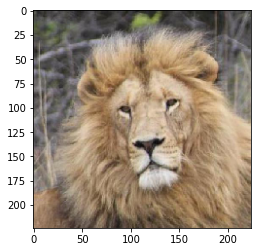

Most similar products........


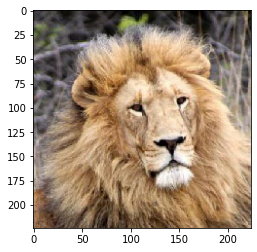

similarity score: 0.984688937664032 | cluster: 0


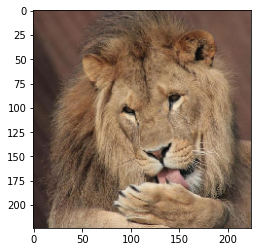

similarity score: 0.9532581567764282 | cluster: 0


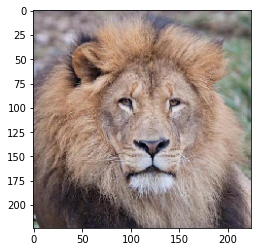

similarity score: 0.9525941014289856 | cluster: 0


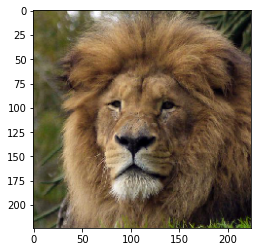

similarity score: 0.9525198936462402 | cluster: 0


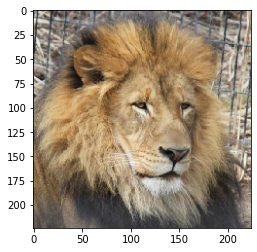

similarity score: 0.950849175453186 | cluster: 0


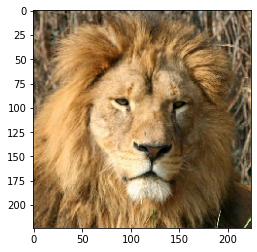

similarity score: 0.9491140842437744 | cluster: 0


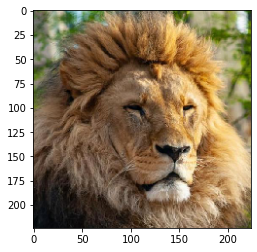

similarity score: 0.9419218301773071 | cluster: 0


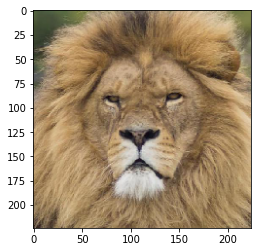

similarity score: 0.941791296005249 | cluster: 0


In [ ]:
retrieve_similar_images(images[98], sim_df, img_df)

In [ ]:
from google.colab import files
new_img = files.upload()

Saving first.png to first (2).png


In [ ]:
extracted_features.shape

(4738, 4096)

Saving first.png to first (6).png


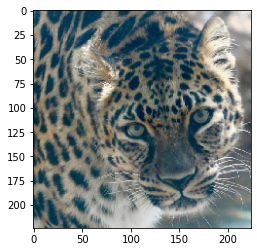

similarity score: 0.7275400161743164 | cluster: 2


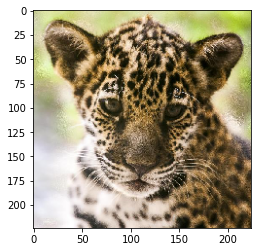

similarity score: 0.7234581708908081 | cluster: 2


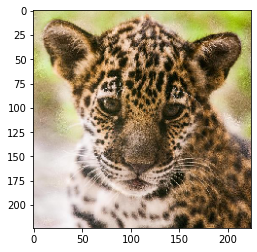

similarity score: 0.7157503366470337 | cluster: 2


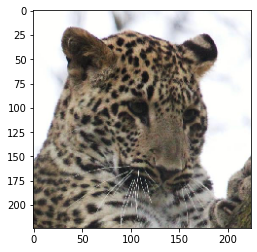

similarity score: 0.7140573263168335 | cluster: 2


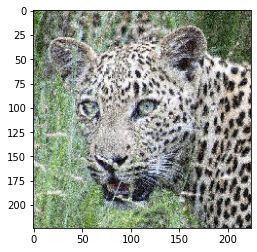

similarity score: 0.7121946811676025 | cluster: 2


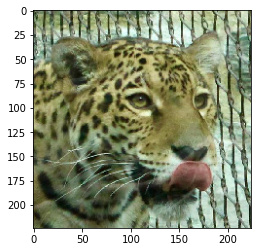

similarity score: 0.7069175243377686 | cluster: 2


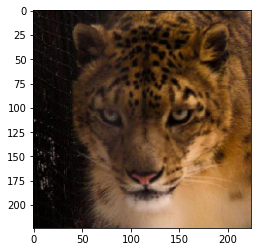

similarity score: 0.7047879695892334 | cluster: 2


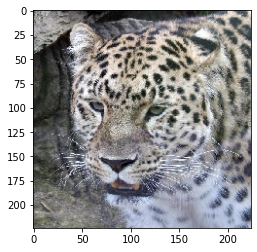

similarity score: 0.7043783068656921 | cluster: 2


In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  up_images = np.vstack([x])
  features = extractor.predict(up_images, batch_size=10)
  new_cosine_sim =cosine_similarity(features, extracted_features)

  new_cosine_sim_1d=new_cosine_sim.ravel()
  top_similar_img_index= a.argsort()[-no:][::-1]
  top_similar_img_scores = new_cosine_sim_1d[top_similar_img_index]

  for index in top_similar_img_index:
    original = load_img(sim_df.index[index], target_size=(imgs_width, imgs_height))
    plt.imshow(original)
    plt.show()
    print('similarity score: {} | cluster: {}'.format(new_cosine_sim_1d[index], img_df.loc[sim_df.index[index],0]) )

In [ ]:
features.shape

(1, 4096)

In [ ]:
features.shape

(1, 4096)

In [ ]:
new_cos_df=cosine_similarity(features, extracted_features)

In [ ]:
new_cos_df

array([[0.35029727, 0.36144912, 0.10683127, ..., 0.58195925, 0.38427943,
        0.5734923 ]], dtype=float32)

In [ ]:
a=new_cos_df.ravel()
a

array([0.35029727, 0.36144912, 0.10683127, ..., 0.58195925, 0.38427943,
       0.5734923 ], dtype=float32)

In [ ]:
no = 8
b= a.argsort()[-no:][::-1]
a[b]

array([0.72754   , 0.7234582 , 0.71575034, 0.7140573 , 0.7121947 ,
       0.7069175 , 0.70478797, 0.7043783 ], dtype=float32)

In [ ]:
b

array([3771,  927, 3252, 4725,  696, 4348,  755, 4675])

In [ ]:
images[0]

'/content/dataset/4106.jpg'

In [ ]:
a[b]

array([0.72754   , 0.7234582 , 0.71575034, 0.7140573 , 0.7121947 ,
       0.7069175 , 0.70478797, 0.7043783 ], dtype=float32)

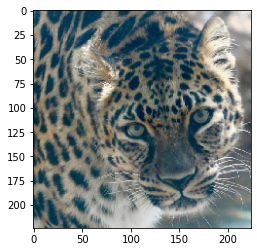

similarity score: 0.7275400161743164 | cluster: 2


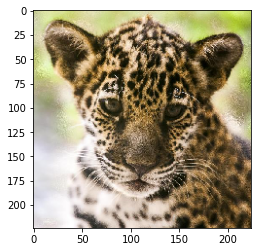

similarity score: 0.7234581708908081 | cluster: 2


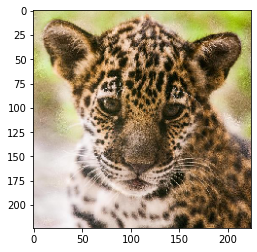

similarity score: 0.7157503366470337 | cluster: 2


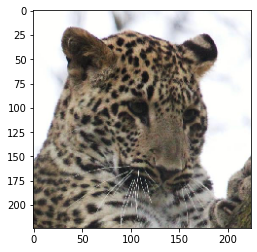

similarity score: 0.7140573263168335 | cluster: 2


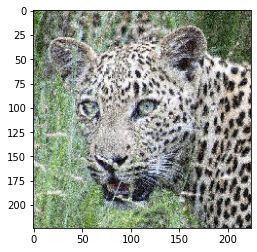

similarity score: 0.7121946811676025 | cluster: 2


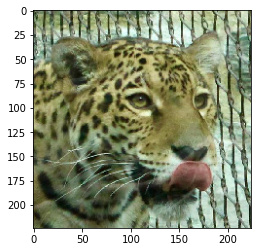

similarity score: 0.7069175243377686 | cluster: 2


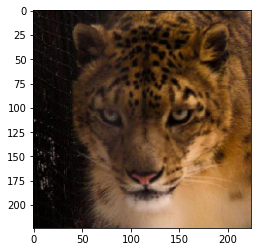

similarity score: 0.7047879695892334 | cluster: 2


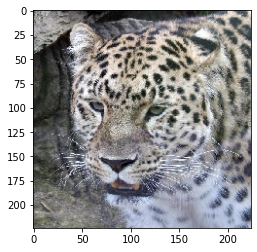

similarity score: 0.7043783068656921 | cluster: 2


In [ ]:
for i,j in enumerate(b):
  original = load_img(sim_df.index[j], target_size=(imgs_width, imgs_height))
  plt.imshow(original)
  plt.show()
  print('similarity score: {} | cluster: {}'.format(a[j], img_df.loc[sim_df.index[j],0]) )

In [ ]:
img_df.loc[sim_df.index[0],0]

0

In [ ]:
def retrieve_similar_images(given_image, cosine_similarity_df, img_df):
    print('Original image belonging to Cluster:', img_df.loc[given_image,0])
    original = load_img(given_image, target_size=(imgs_width, imgs_height))
    plt.imshow(original)
    plt.show()
    
    print('Most similar products........')

    closest_imgs = cosine_similarity_df[given_image].sort_values(ascending=False)[1:nb_closest_images + 1].index
    closest_imgs_scores = cosine_similarity_df[given_image].sort_values(ascending=False)[1:nb_closest_images + 1]

    for i in range(0, len(closest_imgs)):
        original = load_img(closest_imgs[i], target_size=(imgs_width, imgs_height))
        plt.imshow(original)
        plt.show()
        print('similarity score: {} | cluster: {}'.format(closest_imgs_scores[i], img_df.loc[closest_imgs[i],0]) )
    return closest_imgs, closest_imgs_scores

(1, 224, 224, 3)

In [ ]:
k[0]

0.98468894

Original image belonging to Cluster: 0


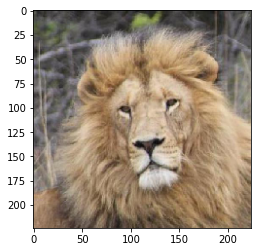

Most similar products........


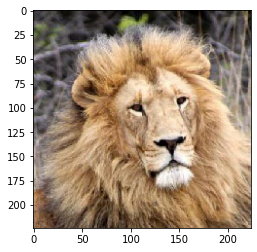

similarity score: 0.984688937664032 | cluster: 0


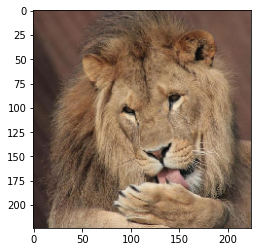

similarity score: 0.9532581567764282 | cluster: 0


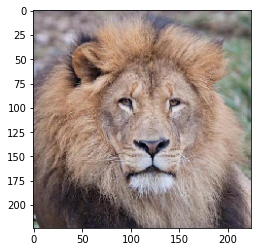

similarity score: 0.9525941014289856 | cluster: 0


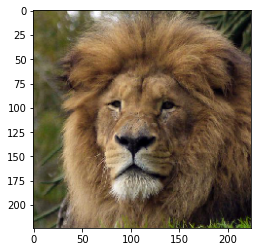

similarity score: 0.9525198936462402 | cluster: 0


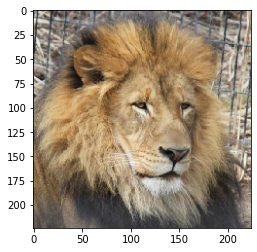

similarity score: 0.950849175453186 | cluster: 0


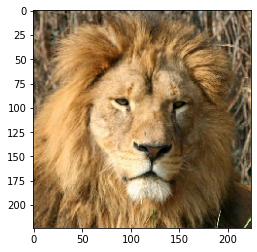

similarity score: 0.9491140842437744 | cluster: 0


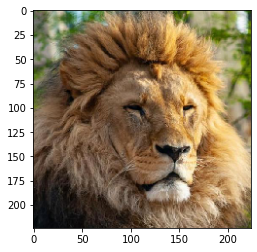

similarity score: 0.9419218301773071 | cluster: 0


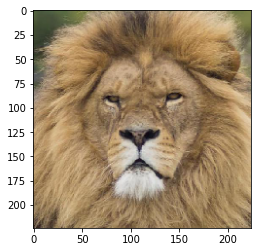

similarity score: 0.941791296005249 | cluster: 0


In [ ]:
h, k = retrieve_similar_images(images[98], sim_df, img_df)

In [ ]:
extracted_features[0].reshape(1,-1)

In [ ]:
 print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a human")
  else:
    print(fn + " is a horse")

In [ ]:
cosine_similarity()

In [ ]:
def test_one_image(files):
    original = load_img(files[0], target_size=(imgs_width, imgs_height))
    plt.imshow(original)
    plt.show()
    print('image successfully loaded')
    return original

def extract_one_image_feature(image):
    numpy_image = img_to_array(image)
    image_batch = np.expand_dims(numpy_image, axis=0)
    print('image batch size', image_batch.shape)
    preprocessed_image = preprocess_input(image_batch.copy())
    return preprocessed_image


In [ ]:
path =os.getcwd()
file_list = glob.glob(os.path.join(path,'dataset/*.jpg'))

In [ ]:
type(img_labels)

NoneType

In [ ]:
def load_trained_model():
    vgg_model = vgg16.VGG16(weights='imagenet')
    feature_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer('fc2').output)
    feature_extractor.summary()
    return feature_extractor